# Classification:02

A notebook to apply an Logistic Regression to classify the flower species type, given some features of the flowers. We will use the the famous Iris dataset (which is now the equivalent of the hello world dataset in the Data Science World)

Based on
- [Kaggle Notebook for Iris Classiifcation](https://www.kaggle.com/code/mohitchaitanya/simple-iris-dataset-classification-using-pytorch)
- [PyTorch for Iris Dataset](https://github.com/mattsinbot/PyTorch-for-Iris-Dataset) 
- [Iris Classification](https://github.com/yangzhangalmo/pytorch-iris/blob/master/main.py)

**Load, Visualize, Summarise Data**

_sklearn_ comes with Iris dataset. We will load it, and do some basic visualization.
It is always a good idea to "look" at the data before (blindly) running any models.

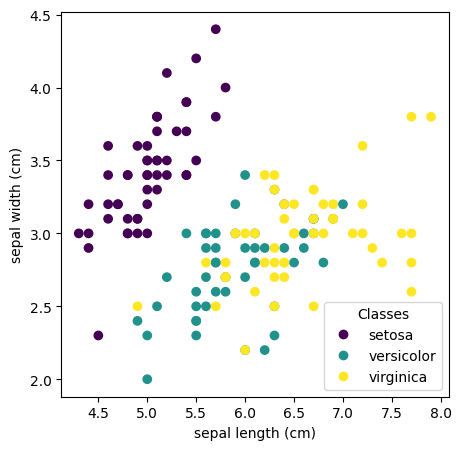

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

We see that, 
1. there are four features, and it is a three class classification problem
2. Using two features (_sepal length_, and _sepal width_), it is clear that, a perceptron will not be able separate _versicolor from _virginica_ (data is not linearly separable) class. 
3. But setosa can be separated from the remaining two.

Let us look at the basic descriptions of the data.

In [2]:

print('feature name',iris.feature_names)
print('features type of data',type(iris.data))
print('features shape',iris.data.shape)
print('feature name',iris.target_names)
print('target type of data',type(iris.target))
print('target shape',iris.target.shape)


feature name ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
features type of data <class 'numpy.ndarray'>
features shape (150, 4)
feature name ['setosa' 'versicolor' 'virginica']
target type of data <class 'numpy.ndarray'>
target shape (150,)


In [3]:
print('target labels',iris.target)

target labels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Ha. In the original dataset, the data is organized by class. If we naively prepare the mini batches (sequentially), model will only see data corresponding to only one class. This will be pretty problematic to get proper gradient signals. We should shuffle the data s.t diversity in the mini batches is maintained.

**Questions**

Imagine you split the data into two batches. One containing only say class 0, and other contains only class 1. During training, the model sees these two batches cyclically. Will the model ever converge. 

1. Will it converge when the data is linearly separable?
2. Will it converge when the data is not linearly separable?
3. Does having a balanced class representation in every mini batch helps? Which way does it?
4. What will be the impact of learning rate when alternating between sets of samples of one class during gradient descent? 

Let us get back to checking the data, this time, from huggingace datasets itself.
Later down the line, it may be useful to learn how to work with [datasets](https://huggingface.co/docs/datasets/en/index) library from HuggingFace. It has deep integrations with PyTorch.

In [5]:
from datasets import Dataset
import pandas as pd
df = pd.read_csv("hf://datasets/scikit-learn/iris/Iris.csv")
df = pd.DataFrame(df)
df.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Interestingly, the first column is ids., which is not useful for us. May be, a perfect system can simply memory the indices and spit out the correct classes. 

And we need to map the Iris types into numerical codes for models to work with. In the _torch_, we can supply integers representing the classes, and we do not have to explicitly pass one-hot coded labels. 

In [7]:
# transform species to numerics
df.loc[df.Species=='Iris-setosa', 'Target'] = 0
df.loc[df.Species=='Iris-versicolor', 'Target'] = 1
df.loc[df.Species=='Iris-virginica', 'Target'] = 2
print(df.Target.unique())
df.head()

[0. 1. 2.]


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Target
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,3,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0.0


In [8]:
# drop the Id columns from the dataframe
df.drop(['Id'],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Target
0,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,0.0


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df[df.columns[0:4]].values
y = df.Target.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)

In [10]:
# dip test:  check that data is shuffled
print(y_train)

[2. 2. 0. 2. 0. 2. 0. 1. 2. 1. 0. 1. 0. 2. 0. 1. 2. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 0. 0. 2.]


**Questions**

Above (visualluy inspecting data) is not a rigorous way (and repeatable way) to test if the data is shuffled (randomly). For numerical labels like integers, in the multi-class or binary class classification problems, which statistical test is suitable to flag if the data grouped?

In [11]:
# scale the features to roughly have zero mean and unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

It is always a good practice to scale the data (features).

1. What might happen if the different features are on different scales? 
2. Does it pose any problems for the optimizer (gradient descent)? 
3. Does it cause any problems w.r.t interpretation of the feature importance?

Suppose instead of 

1. create train, test splits
2. learn the scaling transformation on train data
3. scale both train and test data

``` python
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

you do the following

1. learn the scaling transformation on whole data before split
2. and then create train, test splits

``` python
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)

```

What happens? Should we do this?

## Build a model
Let is build Logistic Classifier

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)

from sklearn.linear_model import LogisticRegression

# Fit the linear regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [13]:
predictions_train = clf.predict(X_train)
predictions_test = clf.predict(X_test)

In [15]:

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(predictions_train,y_train)
test_acc  = accuracy_score(predictions_test,y_test)
print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 96.667
Test Accuracy: 95.833
